In [ ]:
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.data.block import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *

## Loading the data

In [ ]:
source = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(source)
split_idx = GrandparentSplitter(valid_name='val')(items)

In [ ]:
tfms = [PILImage.create, [parent_label, Categorize()]]
ds_img_tfms = [ToTensor(), FlipItem(0.5), RandomResizedCrop(128, min_scale=0.35)]

In [ ]:
dsrc = DataSource(items, tfms, splits=split_idx)

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = broadcast_vec(1, 4, *imagenet_stats)

In [ ]:
dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dbch = dsrc.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=64, num_workers=0)

## Show_batch

Get a batch

In [ ]:
b = dbch.one_batch()

Cast to retained types, decode after batch and before batch

In [ ]:
b = dbch.train_dl.decode(b)

If the batch know how to show itself at this stage, go for it (used for tabular data).

In [ ]:
if hasattr(b, 'show'): b.show(max_n=9)

Grab the samples and decode after_item

In [ ]:
db = dbch.train_dl._decode_batch(b, 9, False)

Get the contexts to show the batch, in this case, a subplot with 9 axis, then show each of the objects on it.

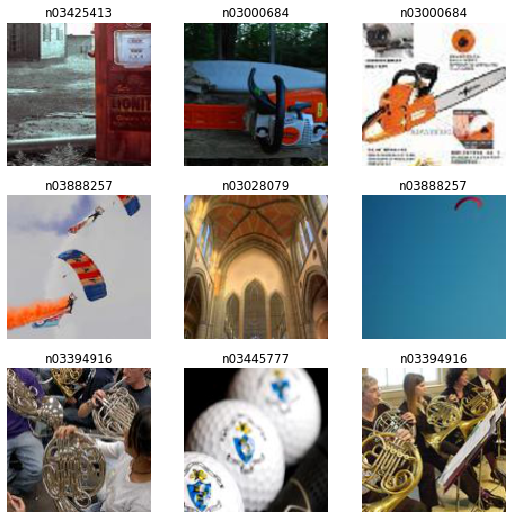

In [ ]:
ctxs = b[0].get_ctxs(max_n=9)
ctxs = [dbch.train_dl.dataset.show(o, ctx=ctx) for o,ctx in zip(db, ctxs)]

## Show results

In [ ]:
learn = cnn_learner(dbch, resnet34)

Get one batch

In [ ]:
b = dbch.one_batch()

Get the corresponding predictions

In [ ]:
preds,_ = learn.get_preds(dl=[b])

Decode the predictions with the loss function

In [ ]:
preds = getattr(learn.loss_func, "decodes", noop)(preds)

At this stage we have two batches to show together: `b` and `(b[0],preds)`. There are two ways of doing this: superposed or aligned.

In [ ]:
b_out = (b[0], preds)

### superposed

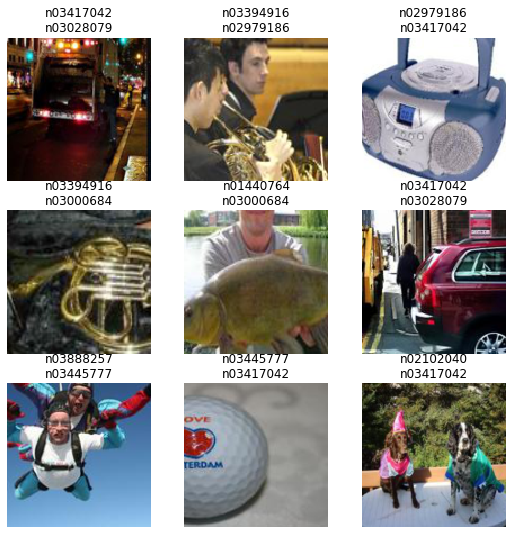

In [ ]:
ctxs = dbch.show_batch(b=b, max_n=9, return_fig=True)
dbch.show_batch(b=b_out, max_n=9, ctxs=ctxs)

### aligned

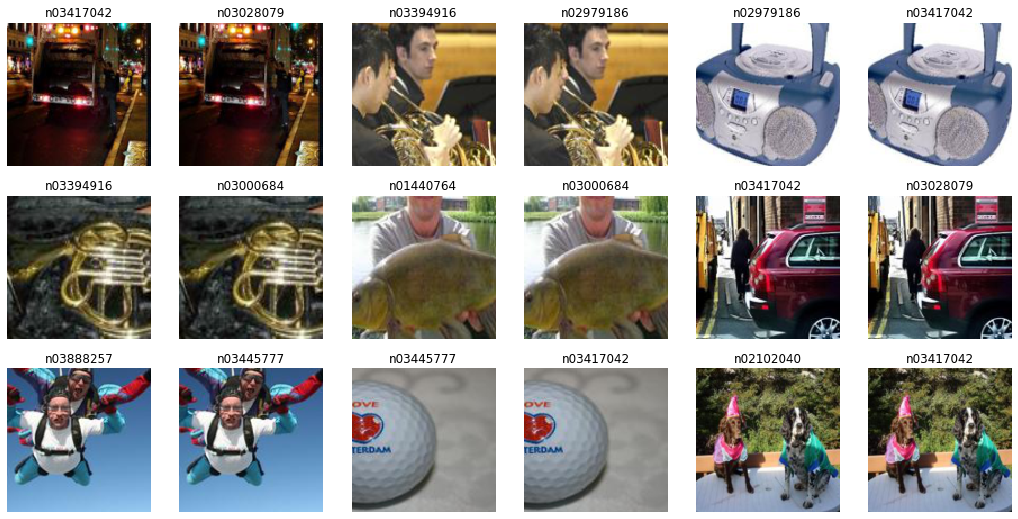

In [ ]:
_,axs = plt.subplots(3, 6, figsize=(18,9))
ctxs1,ctxs2 = axs.flatten()[::2],axs.flatten()[1::2]
dbch.show_batch(b=b,     max_n=9, ctxs=ctxs1)
dbch.show_batch(b=b_out, max_n=9, ctxs=ctxs2)